<a href="https://colab.research.google.com/github/ckshimazaki/CK-Projects/blob/main/Sketch_To_Face_Gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dbxhqwhj
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dbxhqwhj
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=54f48526856b0a07f035d08ea31eb8b24b1d27358bdac68756caab1369db143f
  Stored in directory: /tmp/pip-ephem-wheel-cache-vttccplh/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May  3 19:43:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Data Augmentation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
import glob
from PIL import Image

In [ ]:
def random_shearing(img, num, border):
    rows = img.shape[0]
    cols = img.shape[1]
    if num == 0:
        pts1 = np.float32([[5,5],[20,5],[2,20]])
        pts2 = np.float32([[10,10],[20,5],[5,25]])
    elif num == 1:
        pts1 = np.float32([[5,5],[15,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 2:
        pts1 = np.float32([[5,5],[15,5],[5,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 3:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 4:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    else:
        pts1 = np.float32([[5,5],[10,5],[10,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img, M, (cols,rows), borderValue=border)

def random_rotation(img, degree, border):
    rows = img.shape[0]
    cols = img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degree,1)
    return cv2.warpAffine(img,M,(cols,rows), borderValue=border)

In [ ]:
def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])

    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)

    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt

In [ ]:
#ONLY RUN ONCE

sketch_dir = 'Dataset/Augmented sketch/'
photo_dir = 'Dataset/Augmented photo/'

if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir, exist_ok=True)

if not os.path.exists(photo_dir):
    os.makedirs(photo_dir, exist_ok=True)

p_filenames = glob.glob('/content/drive/MyDrive/Dataset2/PFS/Training photo/*')
s_filenames = glob.glob('/content/drive/MyDrive/Dataset2/PFS/Training sketch/*')

counter = 0
for i in range(len(p_filenames)):
    im = cv2.imread(p_filenames[i])
    sk = cv2.imread(s_filenames[i])

    for j in range(200):
        img, skt = transform_image(im, sk, 40, 10, 10)

        cv2.imwrite(photo_dir + str(counter) + '.jpg', img)
        cv2.imwrite(sketch_dir + str(counter) + '.jpg', skt)

        counter += 1

In [ ]:
counter

17600

Training

In [ ]:
from __future__ import print_function, division
#v
from keras.layers import ELU, PReLU, LeakyReLU

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
#v
from tensorflow.keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [ ]:
#helper function
#------------------------------------

def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')

    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

In [ ]:
#Generator
#---------------------------------
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')


In [ ]:
#Discriminator
#---------------------------------
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

In [ ]:
#GAN
#---------------------------------
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

In [ ]:
#Training GAN
#---------------------------------
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

In [ ]:
#Loss Function
#-------------------------

import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)

    return (0.2 * px_loss) + (0.8 * ctx_loss)

In [ ]:
#Load Dataset
#-----------------------------
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

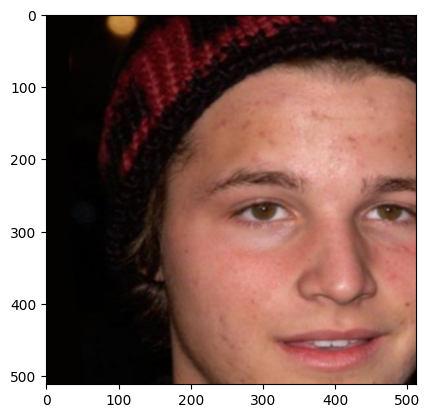

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[17599]).astype('uint8'), cv2.COLOR_BGR2RGB))

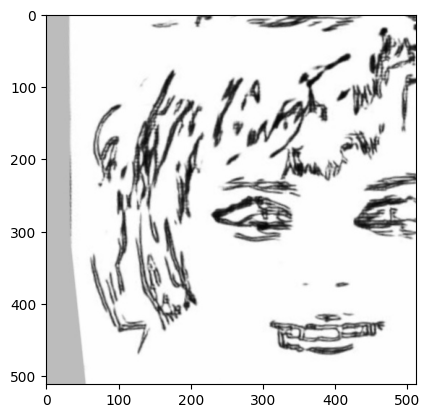

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[17599]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [ ]:
#Define GAN
#-----------------------------
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [ ]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 256, 3)          4182569   ['input_4[0][0]']             
                                                          1                                       
                                                                                                  
 discriminator (Functional)  (None, 64, 64, 1)            539203    ['input_4[0][0]',             
                                                                     'generator[0][0]']           
                                                                                                

In [ ]:
opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

In [ ]:
#smaller subset of data to validate functionality
#----------------------------------------------

import numpy as np

# Define subset ratio
subset_ratio = 0.004  # Use 3% of the dataset to validate quickly
total_samples = len(blue_sketch)  # Assuming both datasets have the same length

# Create a random subset of the data
subset_size = int(total_samples * subset_ratio)
indices = np.random.choice(total_samples, subset_size, replace=False)

# Subset the data
blue_sketch_subset = [blue_sketch[i] for i in indices]
blue_photo_subset = [blue_photo[i] for i in indices]

In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], '/content/drive/MyDrive/MyGANOutputs2/', n_epochs = 100, n_batch=16)
import getpass
authtoken = getpass.getpass()

 ========== Epoch 1 ========== 
1/1 [==============================] - 8s 8s/step
Batch : 1, D Loss : 1.860 | G Loss : 40.830
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 3.052 | G Loss : 28.727
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 2.338 | G Loss : 32.238
1/1 [==============================] - 0s 42ms/step
Batch : 4, D Loss : 1.029 | G Loss : 48.853
1/1 [==============================] - 0s 48ms/step
Batch : 5, D Loss : 4.021 | G Loss : 32.899
1/1 [==============================] - 0s 32ms/step
Batch : 6, D Loss : 3.886 | G Loss : 72.502
1/1 [==============================] - 0s 31ms/step
Batch : 7, D Loss : 3.361 | G Loss : 30.128
1/1 [==============================] - 0s 42ms/step
Batch : 8, D Loss : 1.898 | G Loss : 37.618
1/1 [==============================] - 0s 51ms/step
Batch : 9, D Loss : 2.506 | G Loss : 35.240
1/1 [==============================] - 0s 31ms/step
Batch : 10, D Loss : 3.370 | G Loss : 39.311
1/1 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
1/1 [==============================] - 0s 29ms/step
Batch : 1, D Loss : 3.689 | G Loss : 19.998
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.381 | G Loss : 27.066
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.363 | G Loss : 19.073
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.384 | G Loss : 16.148
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.233 | G Loss : 19.365
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.051 | G Loss : 20.805
1/1 [==============================] - 0s 75ms/step
Batch : 7, D Loss : 3.317 | G Loss : 35.886
1/1 [==============================] - 0s 45ms/step
Batch : 8, D Loss : 3.156 | G Loss : 21.802
1/1 [==============================] - 0s 33ms/step
Batch : 9, D Loss : 3.147 | G Loss : 19.954
1/1 [==============================] - 0s 29ms/step
Batch 

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.283 | G Loss : 42.879
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.303 | G Loss : 18.141
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.328 | G Loss : 20.191
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.472 | G Loss : 18.981
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.580 | G Loss : 21.923
1/1 [==============================] - 0s 34ms/step
Batch : 6, D Loss : 3.491 | G Loss : 18.249
1/1 [==============================] - 0s 56ms/step
Batch : 7, D Loss : 3.592 | G Loss : 17.176
1/1 [==============================] - 0s 29ms/step
Batch : 8, D Loss : 3.155 | G Loss : 33.693
1/1 [==============================] - 0s 28ms/step
Batch : 9, D Loss : 3.206 | G Loss : 20.260
1/1 [==============================] - 0s 29ms/step
Batch 

>Saved: plot_000003.png and g_model & d_model
 ========== Epoch 4 ========== 
1/1 [==============================] - 0s 48ms/step
Batch : 1, D Loss : 3.298 | G Loss : 21.281
1/1 [==============================] - 0s 37ms/step
Batch : 2, D Loss : 3.335 | G Loss : 22.361
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 2.884 | G Loss : 26.874
1/1 [==============================] - 0s 36ms/step
Batch : 4, D Loss : 3.077 | G Loss : 27.112
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.327 | G Loss : 19.140
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.550 | G Loss : 17.046
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.353 | G Loss : 22.069
1/1 [==============================] - 0s 33ms/step
Batch : 8, D Loss : 3.515 | G Loss : 26.079
1/1 [==============================] - 0s 35ms/step
Batch : 9, D Loss : 3.426 | G Loss : 14.589
1/1 [==============================] - 0s 55ms/step
Batch 

>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
1/1 [==============================] - 0s 42ms/step
Batch : 1, D Loss : 3.110 | G Loss : 15.284
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.318 | G Loss : 20.221
1/1 [==============================] - 0s 36ms/step
Batch : 3, D Loss : 2.836 | G Loss : 14.868
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 2.790 | G Loss : 16.639
1/1 [==============================] - 0s 38ms/step
Batch : 5, D Loss : 2.874 | G Loss : 12.638
1/1 [==============================] - 0s 40ms/step
Batch : 6, D Loss : 3.202 | G Loss : 19.862
1/1 [==============================] - 0s 29ms/step
Batch : 7, D Loss : 2.904 | G Loss : 15.018
1/1 [==============================] - 0s 36ms/step
Batch : 8, D Loss : 3.012 | G Loss : 15.296
1/1 [==============================] - 0s 35ms/step
Batch : 9, D Loss : 2.919 | G Loss : 18.660
1/1 [==============================] - 0s 36ms/step
Batch 

>Saved: plot_000005.png and g_model & d_model
 ========== Epoch 6 ========== 
1/1 [==============================] - 0s 42ms/step
Batch : 1, D Loss : 3.009 | G Loss : 16.741
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 2.892 | G Loss : 11.815
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 2.445 | G Loss : 14.724
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 2.913 | G Loss : 13.471
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.118 | G Loss : 16.154
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 2.814 | G Loss : 13.715
1/1 [==============================] - 0s 31ms/step
Batch : 7, D Loss : 2.945 | G Loss : 14.080
1/1 [==============================] - 0s 45ms/step
Batch : 8, D Loss : 3.057 | G Loss : 13.208
1/1 [==============================] - 0s 40ms/step
Batch : 9, D Loss : 2.791 | G Loss : 11.681
1/1 [==============================] - 0s 38ms/step
Batch 

>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
1/1 [==============================] - 0s 33ms/step
Batch : 1, D Loss : 2.725 | G Loss : 12.124
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 2.496 | G Loss : 12.102
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 2.698 | G Loss : 14.856
1/1 [==============================] - 0s 30ms/step
Batch : 4, D Loss : 2.669 | G Loss : 11.098
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 2.880 | G Loss : 10.778
1/1 [==============================] - 0s 50ms/step
Batch : 6, D Loss : 2.752 | G Loss : 11.208
1/1 [==============================] - 0s 41ms/step
Batch : 7, D Loss : 2.746 | G Loss : 11.177
1/1 [==============================] - 0s 71ms/step
Batch : 8, D Loss : 2.746 | G Loss : 10.743
1/1 [==============================] - 0s 37ms/step
Batch : 9, D Loss : 2.872 | G Loss : 13.201
1/1 [==============================] - 0s 39ms/step
Batch 

>Saved: plot_000007.png and g_model & d_model
 ========== Epoch 8 ========== 
1/1 [==============================] - 0s 38ms/step
Batch : 1, D Loss : 2.921 | G Loss : 10.189
1/1 [==============================] - 0s 56ms/step
Batch : 2, D Loss : 3.028 | G Loss : 9.110
1/1 [==============================] - 0s 40ms/step
Batch : 3, D Loss : 2.801 | G Loss : 9.478
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 2.635 | G Loss : 10.784
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 2.999 | G Loss : 9.380
1/1 [==============================] - 0s 33ms/step
Batch : 6, D Loss : 3.000 | G Loss : 9.404
1/1 [==============================] - 0s 26ms/step
Batch : 7, D Loss : 2.701 | G Loss : 10.061
1/1 [==============================] - 0s 39ms/step
Batch : 8, D Loss : 3.023 | G Loss : 7.542
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.032 | G Loss : 9.939
1/1 [==============================] - 0s 38ms/step
Batch : 10, 

>Saved: plot_000008.png and g_model & d_model
 ========== Epoch 9 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 2.432 | G Loss : 7.995
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 2.577 | G Loss : 8.893
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 2.761 | G Loss : 8.980
1/1 [==============================] - 0s 33ms/step
Batch : 4, D Loss : 3.019 | G Loss : 8.499
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 2.438 | G Loss : 7.741
1/1 [==============================] - 0s 32ms/step
Batch : 6, D Loss : 2.924 | G Loss : 8.178
1/1 [==============================] - 0s 67ms/step
Batch : 7, D Loss : 3.068 | G Loss : 7.997
1/1 [==============================] - 0s 58ms/step
Batch : 8, D Loss : 3.002 | G Loss : 9.294
1/1 [==============================] - 0s 35ms/step
Batch : 9, D Loss : 2.787 | G Loss : 7.700
1/1 [==============================] - 0s 29ms/step
Batch : 10, D L

>Saved: plot_000009.png and g_model & d_model
 ========== Epoch 10 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 2.487 | G Loss : 7.736
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 2.889 | G Loss : 7.594
1/1 [==============================] - 0s 45ms/step
Batch : 3, D Loss : 2.460 | G Loss : 7.148
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.076 | G Loss : 7.104
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.038 | G Loss : 8.480
1/1 [==============================] - 0s 69ms/step
Batch : 6, D Loss : 2.998 | G Loss : 8.281
1/1 [==============================] - 0s 78ms/step
Batch : 7, D Loss : 2.923 | G Loss : 7.066
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.039 | G Loss : 7.920
1/1 [==============================] - 0s 32ms/step
Batch : 9, D Loss : 3.014 | G Loss : 7.532
1/1 [==============================] - 0s 27ms/step
Batch : 10, D 

>Saved: plot_000010.png and g_model & d_model
 ========== Epoch 11 ========== 
1/1 [==============================] - 0s 29ms/step
Batch : 1, D Loss : 2.756 | G Loss : 7.275
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.151 | G Loss : 6.514
1/1 [==============================] - 0s 34ms/step
Batch : 3, D Loss : 3.045 | G Loss : 7.392
1/1 [==============================] - 0s 40ms/step
Batch : 4, D Loss : 2.650 | G Loss : 6.804
1/1 [==============================] - 0s 40ms/step
Batch : 5, D Loss : 2.842 | G Loss : 7.381
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 2.649 | G Loss : 7.342
1/1 [==============================] - 0s 29ms/step
Batch : 7, D Loss : 2.816 | G Loss : 7.578
1/1 [==============================] - 0s 38ms/step
Batch : 8, D Loss : 3.019 | G Loss : 7.242
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 2.823 | G Loss : 6.792
1/1 [==============================] - 0s 30ms/step
Batch : 10, D 

>Saved: plot_000011.png and g_model & d_model
 ========== Epoch 12 ========== 
1/1 [==============================] - 0s 46ms/step
Batch : 1, D Loss : 2.705 | G Loss : 7.991
1/1 [==============================] - 0s 36ms/step
Batch : 2, D Loss : 2.971 | G Loss : 9.142
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.091 | G Loss : 9.413
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 2.862 | G Loss : 8.003
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 2.836 | G Loss : 7.484
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 2.593 | G Loss : 7.911
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 2.535 | G Loss : 8.115
1/1 [==============================] - 0s 32ms/step
Batch : 8, D Loss : 3.011 | G Loss : 6.661
1/1 [==============================] - 0s 32ms/step
Batch : 9, D Loss : 2.905 | G Loss : 7.172
1/1 [==============================] - 0s 58ms/step
Batch : 10, D 

>Saved: plot_000012.png and g_model & d_model
 ========== Epoch 13 ========== 
1/1 [==============================] - 0s 59ms/step
Batch : 1, D Loss : 2.970 | G Loss : 6.019
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 2.995 | G Loss : 7.015
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 2.814 | G Loss : 5.940
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 2.928 | G Loss : 7.492
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 2.883 | G Loss : 6.923
1/1 [==============================] - 0s 29ms/step
Batch : 6, D Loss : 2.853 | G Loss : 6.338
1/1 [==============================] - 0s 28ms/step
Batch : 7, D Loss : 2.688 | G Loss : 7.209
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 2.928 | G Loss : 6.507
1/1 [==============================] - 0s 36ms/step
Batch : 9, D Loss : 3.014 | G Loss : 7.441
1/1 [==============================] - 0s 27ms/step
Batch : 10, D 